Employee Departure Prediction (Supervised Learning)

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/midterm/employee_departure_dataset.csv')

In [3]:
df.head()

,Unnamed: 0,RecordId,Gender,Distance,YearsWorked,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left
0,0,1002332,1,>30miles,10,63K,65K,4.0,5.0,2,0
1,1,1002333,0,~10miles,7,54K,56K,4.0,4.0,2,0
2,2,1002334,0,<5mile,5,60K,61K,4.0,4.0,3,0
3,3,1002335,0,~15miles,4,59K,60K,5.0,5.0,7,0
4,4,1002336,1,~20miles,6,61K,63K,5.0,5.0,5,0


In [4]:
df.shape

(300000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300000 non-null  int64  
 1   RecordId          300000 non-null  int64  
 2   Gender            300000 non-null  int64  
 3   Distance          299735 non-null  object 
 4   YearsWorked       300000 non-null  int64  
 5   PreviousSalary    300000 non-null  object 
 6   Salary            300000 non-null  object 
 7   SelfReview        299416 non-null  float64
 8   SupervisorReview  299424 non-null  float64
 9   DepartmentCode    300000 non-null  int64  
 10  Left              300000 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 25.2+ MB


In [6]:
df.isna().sum()

Unnamed: 0            0
RecordId              0
Gender                0
Distance            265
YearsWorked           0
PreviousSalary        0
Salary                0
SelfReview          584
SupervisorReview    576
DepartmentCode        0
Left                  0
dtype: int64

Distance, SelfReview and SupervisorReview columns contains nulls

In [7]:
df['Gender'].value_counts()

0    179687
1    120313
Name: Gender, dtype: int64

In [8]:
df['Distance'].value_counts()

~10miles    90148
~15miles    89667
~20miles    59836
>30miles    30218
<5mile      29866
Name: Distance, dtype: int64

Distance column needs cleaning

In [9]:
df['Salary'].value_counts()

61K    37943
62K    37051
63K    34922
60K    33943
59K    28141
64K    27940
58K    20849
65K    15813
66K    14486
57K    14348
56K     8965
67K     8282
55K     5378
68K     3985
54K     2884
69K     1592
53K     1440
52K      706
70K      580
50K      213
51K      209
71K      173
49K       71
48K       33
72K       33
47K        9
46K        6
73K        3
45K        1
74K        1
Name: Salary, dtype: int64

In [10]:
df['PreviousSalary'].value_counts()

60K    39790
59K    38557
61K    37276
58K    33261
62K    30679
57K    26071
63K    21774
56K    18927
64K    13922
55K    12367
54K     7532
65K     7147
53K     4291
66K     3056
52K     2221
51K     1024
67K     1006
50K      463
68K      253
49K      218
48K       75
69K       40
47K       34
46K        9
45K        6
70K        1
Name: PreviousSalary, dtype: int64

Salary column contains values in K format. Need to change the values to 1000s' and need to convert datatype

In [11]:
df['DepartmentCode'].value_counts()

2    50194
1    50140
5    50060
7    49946
6    49938
3    49722
Name: DepartmentCode, dtype: int64

Department code is a numerical in value but considered as categorical as per the context

In [12]:
df['Left'].value_counts()

0    230450
1     69550
Name: Left, dtype: int64

## Intial Observations

The dataset is about an organisation and its employees data. The dataset also contains a column that represents whether the employee is currently working in the organisation or not.

After the examination of first few rows and column values, these are our assumptions on the dataset.


* The dataset contains 300K rows and 11 columns.

* Out of 11 columns, 9 columns are relevant to the employee which includes  

    1. Gender
    2. Distance (away from the company location)
    3. YearsWorked (in the company)
    4. PreviousSalary (in the company)
    5. Salary (Current)
    6. SelfReview
    7. SupervisorReview
    8. DepartmentCode
    9. Left (label that represents whether employee is the current  or former one)

Now the aim of this project is to use this data to predict the possiblity of an employee leaving the organisation in the near future.



# Data Cleaning

In [13]:
# Filling the -1 in place of nan values to extract numericals
df['Distance'].fillna(-1, inplace=True)
df['PreviousSalary'].fillna(-1, inplace=True)
df['Salary'].fillna(-1, inplace=True)

# Extracting numerical values from the distance, previous salary and salary columns
df['Distance'] = df['Distance'].str.extract(r'(\d+)').astype('Int64')
df['PreviousSalary'] = df['PreviousSalary'].str.extract(r'(\d+)').astype('Int64')
df['Salary'] = df['Salary'].str.extract(r'(\d+)').astype('Int64')

In [14]:
# Replacing -1 value back to nan value in the respective columns
df['Distance'].replace(-1, np.nan, inplace=True)
df['PreviousSalary'].replace(-1, np.nan, inplace=True)
df['Salary'].replace(-1, np.nan, inplace=True)

In [15]:
# Changing the type of DepartmentCode column to string
df['DepartmentCode'] = df['DepartmentCode'].astype(str)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300000 non-null  int64  
 1   RecordId          300000 non-null  int64  
 2   Gender            300000 non-null  int64  
 3   Distance          299735 non-null  Int64  
 4   YearsWorked       300000 non-null  int64  
 5   PreviousSalary    300000 non-null  Int64  
 6   Salary            300000 non-null  Int64  
 7   SelfReview        299416 non-null  float64
 8   SupervisorReview  299424 non-null  float64
 9   DepartmentCode    300000 non-null  object 
 10  Left              300000 non-null  int64  
dtypes: Int64(3), float64(2), int64(5), object(1)
memory usage: 26.0+ MB


# Exploratory data analysis

## Univariate Analysis

<Figure size 400x400 with 0 Axes>

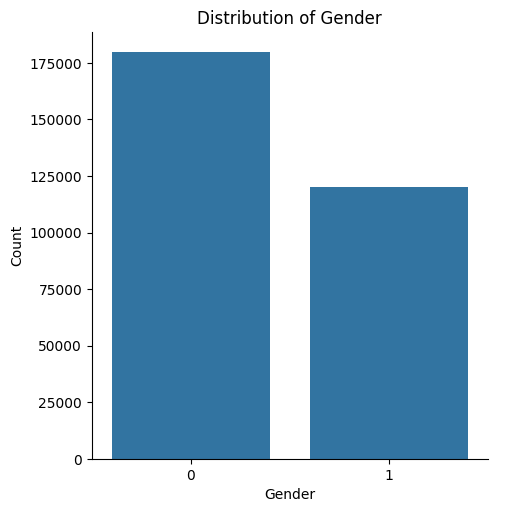

In [17]:
plt.figure(figsize=(4, 4))
sns.catplot(data=df, x="Gender", kind="count")
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

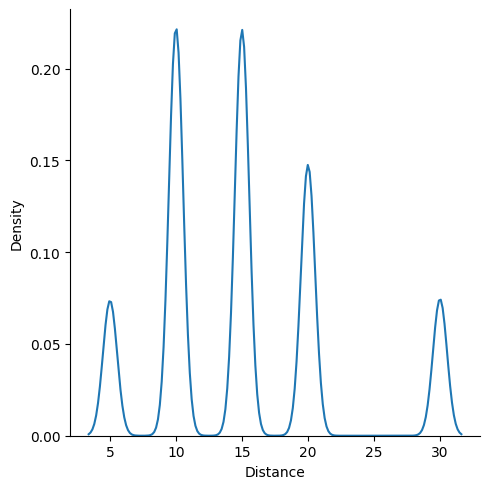

In [18]:
sns.displot(df, x="Distance", kind="kde")

Most workers reside within a 10-to 20-mile radius.

<Figure size 300x300 with 0 Axes>

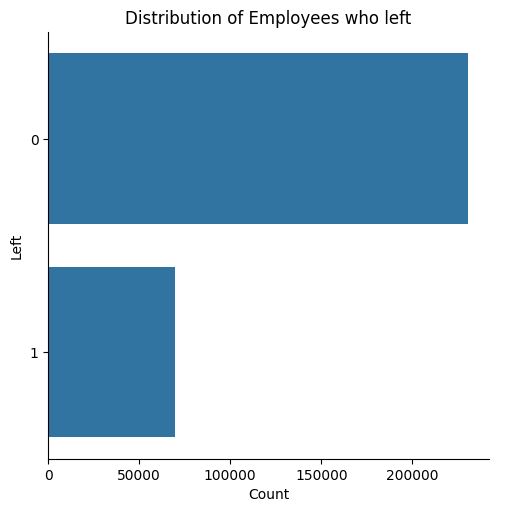

In [19]:
plt.figure(figsize=(3, 3))
sns.catplot(data=df, y="Left", kind="count")
plt.title('Distribution of Employees who left')
plt.xlabel('Count')
plt.ylabel('Left')
plt.show()

## The count of employees who have left is more than the existing employees thus making the dataset unbalanced.


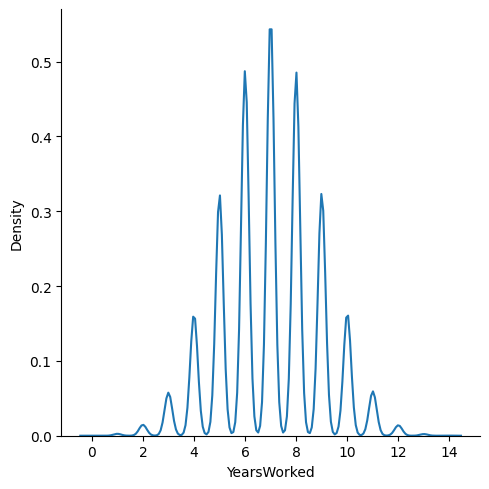

In [20]:
sns.displot(df, x="YearsWorked", kind="kde")

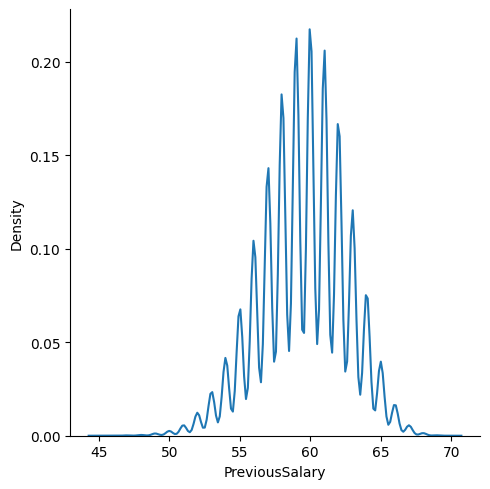

In [21]:
sns.displot(df, x="PreviousSalary", kind="kde")

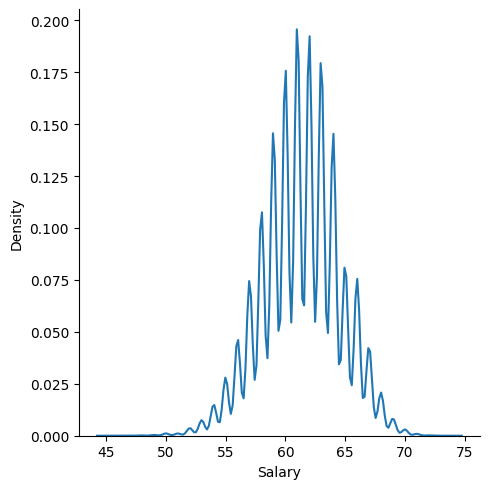

In [22]:
sns.displot(df, x="Salary", kind="kde")

## Bivariate Analysis

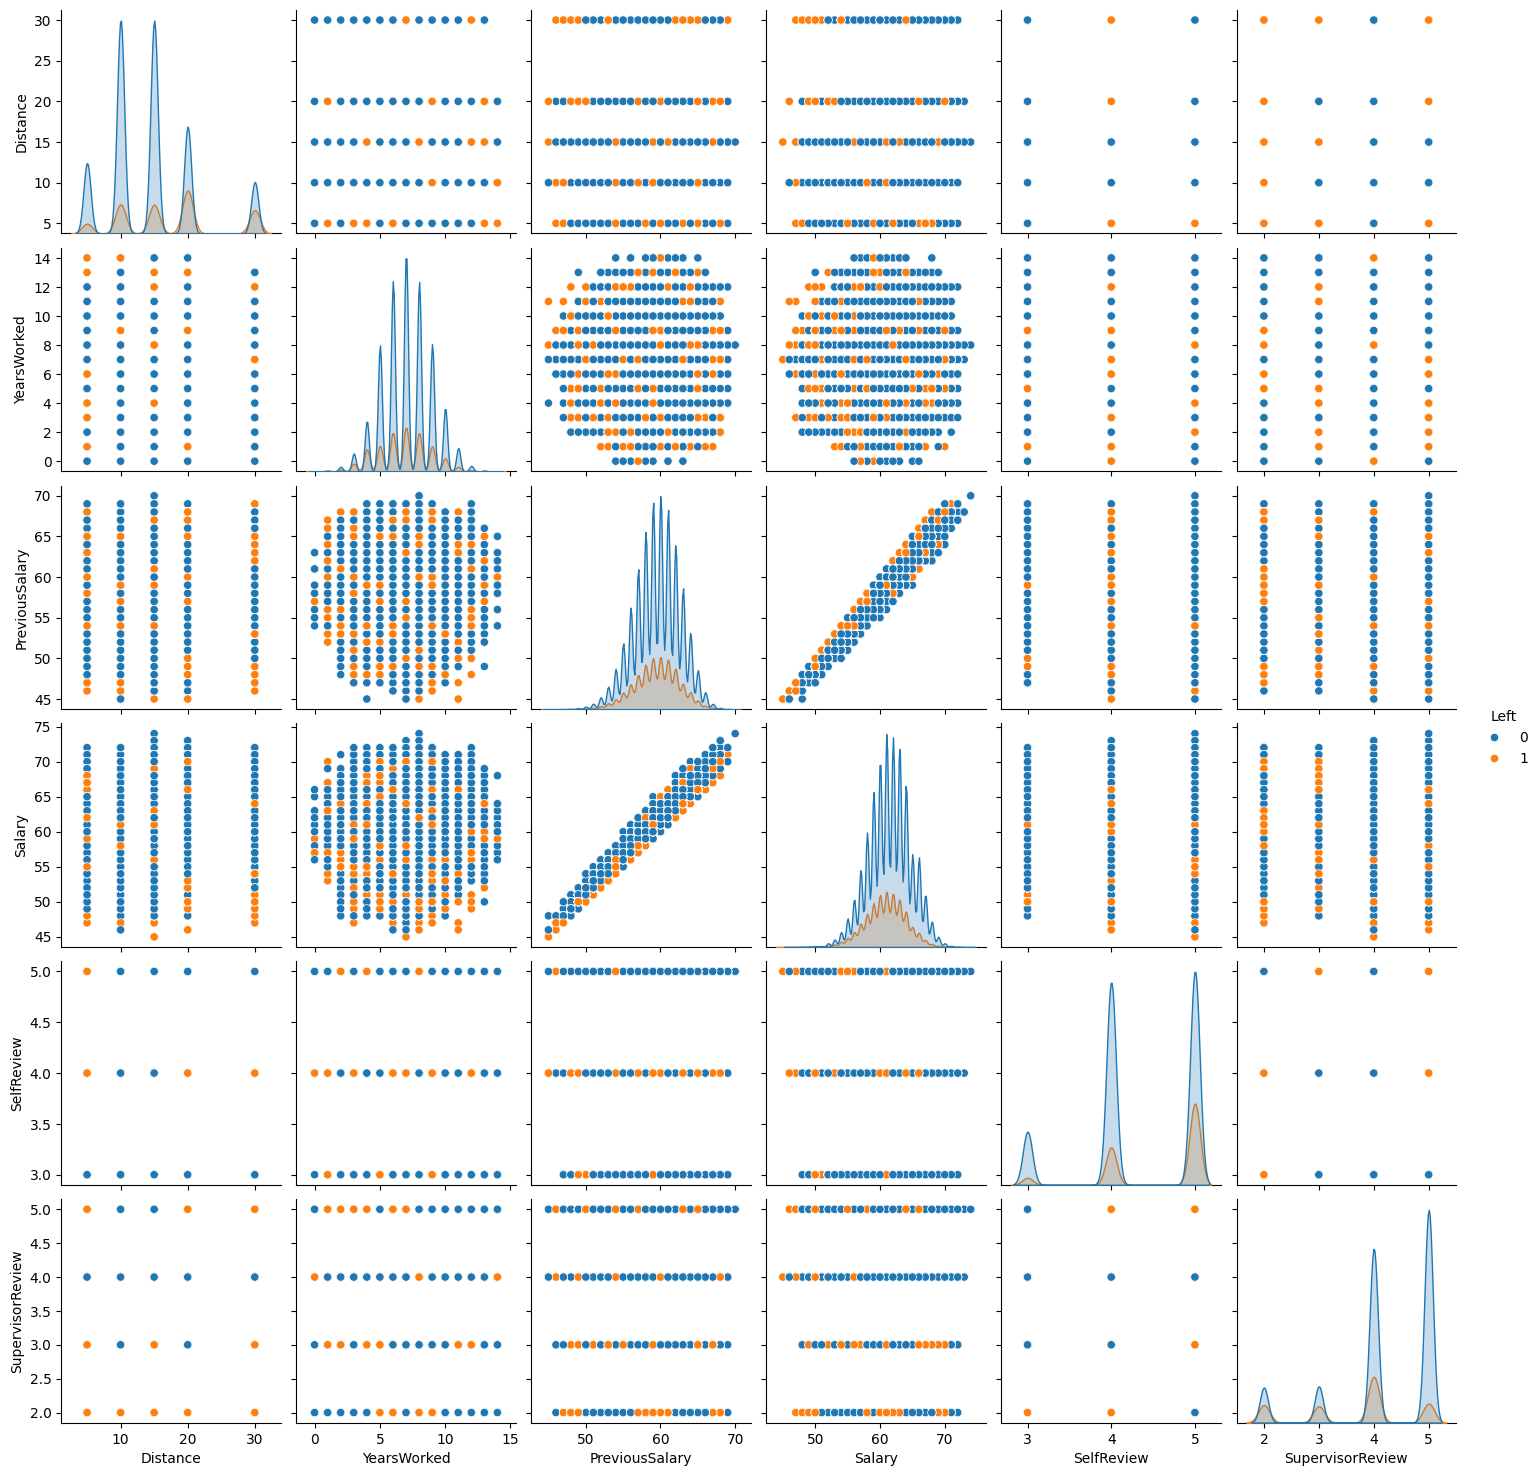

In [24]:
sns.pairplot(df[['Distance', 'YearsWorked', 'PreviousSalary', 'Salary', 'SelfReview', 'SupervisorReview', 'Left']], hue= 'Left')
plt.show()

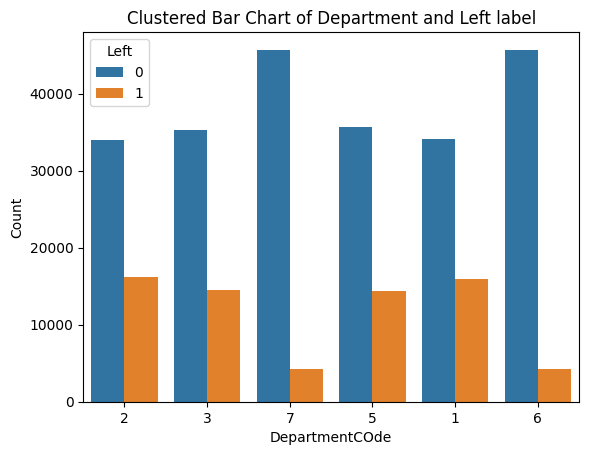

In [25]:
sns.countplot(x=df['DepartmentCode'], hue=df['Left'], data=df)
plt.title('Clustered Bar Chart of Department and Left label')
plt.xlabel('DepartmentCOde')
plt.ylabel('Count')
plt.show()

## Here we see that some departments have huge variation in attrition of employees, making it a important feature to consider further.

# Feature Selection

In [26]:
temp_df = df[['Gender', 'Distance', 'YearsWorked',
       'PreviousSalary', 'Salary', 'SelfReview', 'SupervisorReview',
       'DepartmentCode', 'Left']]

In [27]:
temp_df.columns

Index(['Gender', 'Distance', 'YearsWorked', 'PreviousSalary', 'Salary',
       'SelfReview', 'SupervisorReview', 'DepartmentCode', 'Left'],
      dtype='object')

In [28]:
temp_df.apply(lambda x:sum(x.isnull()), axis =0)

Gender                0
Distance            265
YearsWorked           0
PreviousSalary        0
Salary                0
SelfReview          584
SupervisorReview    576
DepartmentCode        0
Left                  0
dtype: int64

In [29]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Gender            300000 non-null  int64  
 1   Distance          299735 non-null  Int64  
 2   YearsWorked       300000 non-null  int64  
 3   PreviousSalary    300000 non-null  Int64  
 4   Salary            300000 non-null  Int64  
 5   SelfReview        299416 non-null  float64
 6   SupervisorReview  299424 non-null  float64
 7   DepartmentCode    300000 non-null  object 
 8   Left              300000 non-null  int64  
dtypes: Int64(3), float64(2), int64(3), object(1)
memory usage: 21.5+ MB


Filling null values in the temp_df with median imputation for numerical columns and mode imputation for categorical columns

In [30]:
temp_df['Distance'].fillna(temp_df['Distance'].median(), inplace=True)

<ipython-input-30-6860aa0b04c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Distance'].fillna(temp_df['Distance'].median(), inplace=True)


In [31]:
temp_df['SelfReview'].fillna(temp_df['SelfReview'].median(), inplace=True)

<ipython-input-31-12257f3bc5d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['SelfReview'].fillna(temp_df['SelfReview'].median(), inplace=True)


In [32]:
temp_df['SupervisorReview'].fillna(temp_df['SupervisorReview'].median(), inplace=True)

<ipython-input-32-205e3f8c1f4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['SupervisorReview'].fillna(temp_df['SupervisorReview'].median(), inplace=True)


In [33]:
temp_df.apply(lambda x:sum(x.isnull()), axis =0)

Gender              0
Distance            0
YearsWorked         0
PreviousSalary      0
Salary              0
SelfReview          0
SupervisorReview    0
DepartmentCode      0
Left                0
dtype: int64

## Categorical Feature Analysis

In [34]:
cat_df = temp_df[['Gender', 'DepartmentCode', 'Left']]
cat_df.head()

,Gender,DepartmentCode,Left
0,1,2,0
1,0,2,0
2,0,3,0
3,0,7,0
4,1,5,0


In [35]:
from sklearn.preprocessing import LabelEncoder
for col in cat_df.columns:
    le = LabelEncoder()
    cat_df[col] = le.fit_transform(cat_df[col])
cat_df.head()

<ipython-input-35-3114cc7f96d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df[col] = le.fit_transform(cat_df[col])
<ipython-input-35-3114cc7f96d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df[col] = le.fit_transform(cat_df[col])
<ipython-input-35-3114cc7f96d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,Gender,DepartmentCode,Left
0,1,1,0
1,0,1,0
2,0,2,0
3,0,5,0
4,1,3,0


In [57]:
features = ['Gender', 'Distance', 'YearsWorked', 'PreviousSalary', 'Salary', 'SelfReview',
            'SupervisorReview', 'DepartmentCode']

features_cat = ['Gender', 'DepartmentCode']

X = cat_df[features_cat]
y = cat_df['Left']


### Method 1 - Chi-Squared (chi2)

In [58]:
from sklearn.feature_selection import SelectKBest, chi2
chi_scores = chi2(X, y)
chi_scores

(array([ 1151.24604156, 16724.92855515]),
 array([2.40479456e-252, 0.00000000e+000]))

<Axes: >

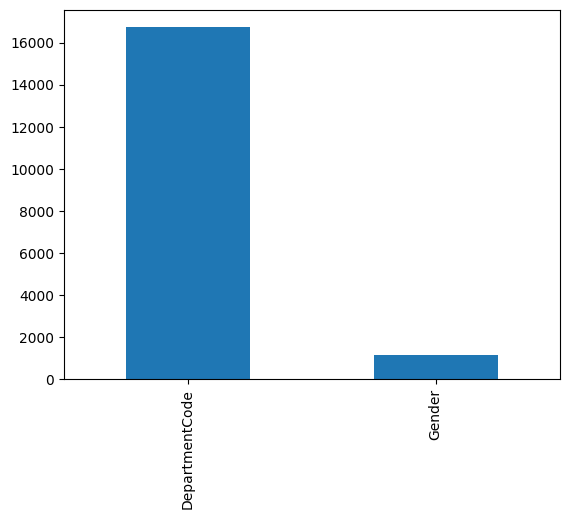

In [59]:
# higher the chi value, higher the importance
chi_values = pd.Series(chi_scores[0], index=X.columns)
chi_values.sort_values(ascending=False, inplace=True)
chi_values.plot.bar()

<Axes: >

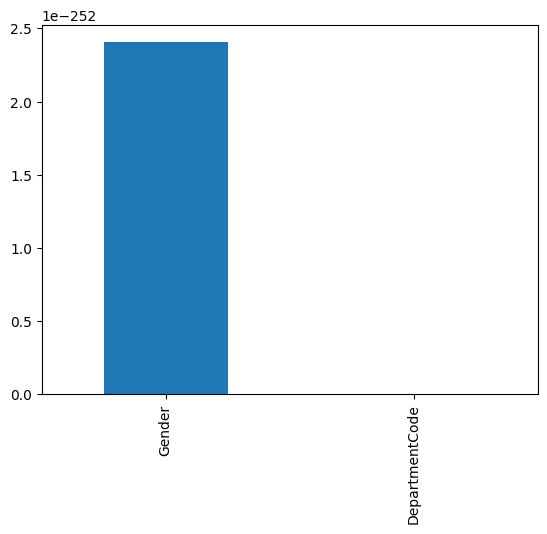

In [60]:
# if p-value > 0.05, lower the importance
p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

From the above chi-square scores and p-values we can see that Department Code has much influence on the employees than the Gender

## Numerical Feature Analysis

### Correlation analysis

In [61]:
num_df = temp_df[['Distance', 'YearsWorked', 'PreviousSalary', 'Salary', 'SelfReview', 'SupervisorReview', 'Left']]

<Axes: title={'center': 'Correlation Analysis between Numerical features and Target variable'}>

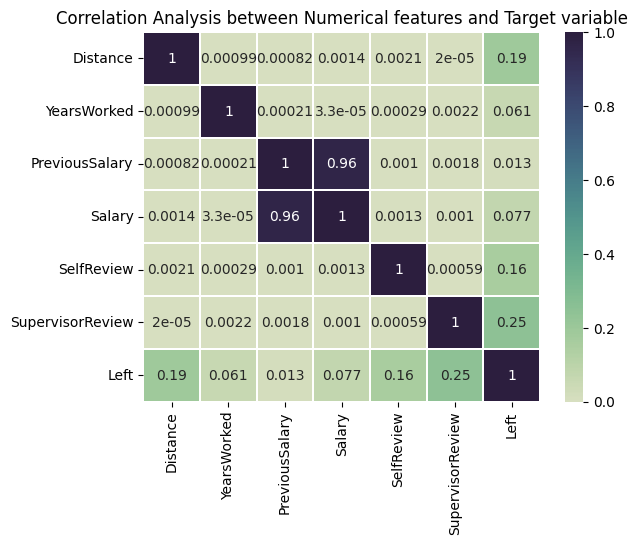

In [62]:
colormap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
plt.title('Correlation Analysis between Numerical features and Target variable')
sns.heatmap(num_df.corr().abs(),  annot=True, cmap=colormap, linewidths=0.2, vmin=0, vmax=1)

From the above heatmap we can see that correlation strengths between Left (Target) and features are in the following order of SupervisorReview , Distance, SelfReview, Salary, YearsWorked, PreviousSalary in the following order from highest to lower

In [64]:
features_num = ['Distance', 'YearsWorked', 'PreviousSalary', 'Salary', 'SelfReview', 'SupervisorReview']

X = num_df[features_num]
y = num_df['Left']


### Method 1 - ANOVA F-Value (for numerical features)

In [65]:
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming X contains your numerical features and y is the categorical output
selector_anova = SelectKBest(score_func=f_classif, k=6)
X_selected_anova = selector_anova.fit_transform(X, y)

scores_anova = selector_anova.scores_
print("ANOVA F-Value Scores:", scores_anova)


ANOVA F-Value Scores: [11842.78719251  1112.60202707    47.61711157  1786.41791571
  7615.08747415 19881.29702219]


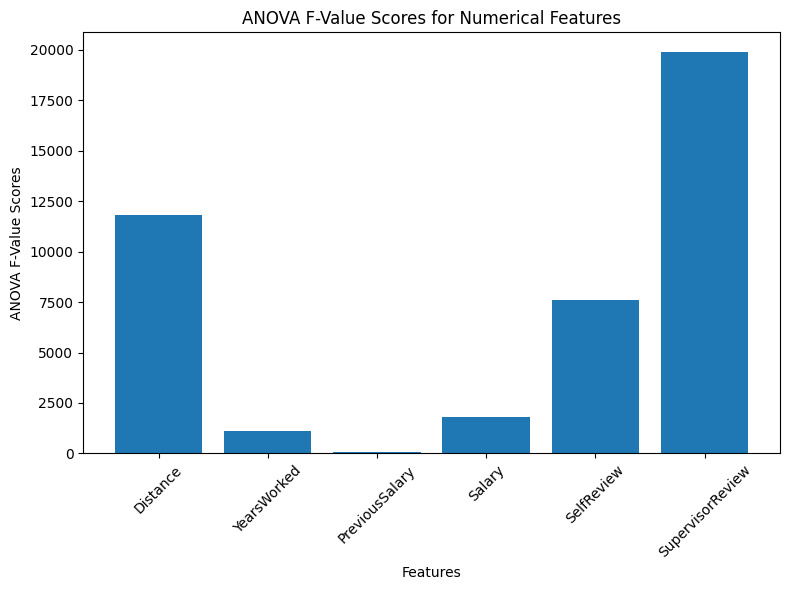

In [66]:
plt.figure(figsize=(8, 6))
plt.bar(features_num,scores_anova)
plt.xlabel('Features')
plt.ylabel('ANOVA F-Value Scores')
plt.title('ANOVA F-Value Scores for Numerical Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

From the ANOVA test of numerical features and target variables as well we get the features SupervisorReview , Distance, SelfReview, Salary, YearsWorked are seemed to be influencing more on the target variable

From the above heatmap we can see that correlation between Left (Target) and features SupervisorReview , Distance, SelfReview, Salary, YearsWorked in the following order

So After the careful analysis between features and target variable below are the features that we have considered for the classification model.

1. DepartmentCode
2. SupervisorReview
3. Distance
4. SelfReview
5. Salary
6. YearsWorked
7. PreviousSalary


In [112]:
num_vars = [ "SupervisorReview", "Distance", "SelfReview", "Salary", "YearsWorked", "PreviousSalary"]

cat_vars = ["DepartmentCode"]

# Feature Engineering

In [113]:
num_pipeline = Pipeline([
    ('impute_missing', SimpleImputer(strategy='median')),
    ('standardize_num', StandardScaler())
])

cat_pipeline = Pipeline([
    ('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
    ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Clubbing both the numerical and categorical pipeline.
processing_pipeline = ColumnTransformer(transformers=[
    ('num pipeline', num_pipeline, num_vars),
    ('cat pipeline', cat_pipeline, cat_vars)
])
processing_pipeline

ColumnTransformer(transformers=[('num pipeline',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['SupervisorReview', 'Distance', 'SelfReview',
                                  'Salary', 'YearsWorked', 'PreviousSalary']),
                                ('cat pipeline',
                                 Pipeline(steps=[('impute_missing_cats',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['DepartmentCode'])])

Before training the model on the entire dataset, lets take a sample dataset of 20,000 records and try out different models and evaluate them on different metrics

# Modelling

## Training the models with whole dataset

In [114]:
# train test split of the subset dataset
X_train, X_test, y_train, y_test = train_test_split(df[num_vars+cat_vars], df["Left"], test_size=0.95, random_state=42)

print(f'Subset Training samples: {X_train.shape[0]:,}')
print(f'Subset Test samples: {X_test.shape[0]:,}')

Subset Training samples: 15,000
Subset Test samples: 285,000


### Logistic Regression

In [115]:
lr_base_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('log', LogisticRegression())]

)
lr_base_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('log', LogisticRegression())])

In [116]:
lr_base_modeling_pipeline = lr_base_modeling_pipeline.fit(X_train, y_train)

In [200]:
y_test_lr_base = lr_base_modeling_pipeline.predict(X_test)
y_testpr_lr_base = lr_base_modeling_pipeline.predict_proba(X_test)

In [193]:
y_train_lr_base = lr_base_modeling_pipeline.predict(X_train)
train_f1_score = f1_score(y_train, y_train_lr_base)
print("Training F1 Score:", train_f1_score)

Training F1 Score: 0.5126760563380283


In [194]:
test_f1_score = f1_score(y_test, y_test_lr_base)
print("Testing F1 Score:", test_f1_score)

Testing F1 Score: 0.5072646638585293


In [201]:
print("ROC_AUC_lr ",(roc_auc_score(y_test,y_test_lr_base)*100))
cf_lrb = confusion_matrix(y_test,y_test_lr_base)

ROC_AUC_lr  67.40479420286024


### Decision Tree

In [121]:
dt_base_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('dt', DecisionTreeClassifier())]
)
dt_base_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('dt', DecisionTreeClassifier())])

In [122]:
dt_base_modeling_pipeline = dt_base_modeling_pipeline.fit(X_train, y_train)

In [202]:
y_test_dt_base = dt_base_modeling_pipeline.predict(X_test)
y_testpr_dt_base = dt_base_modeling_pipeline.predict_proba(X_test)

In [196]:
y_train_dt_base = dt_base_modeling_pipeline.predict(X_train)
train_f1_score = f1_score(y_train, y_train_dt_base)
print("Training F1 Score:", train_f1_score)
print()
test_f1_score = f1_score(y_test, y_test_dt_base)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.9531990521327014

Testing F1 Score: 0.623853353891199


In [203]:
print("ROC_AUC_dt ",(roc_auc_score(y_test,y_test_dt_base)*100))
cf_dtb = confusion_matrix(y_test,y_test_dt_base)

ROC_AUC_dt  75.22291053145072


### Random Forest

In [127]:
rf_base_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('rf', RandomForestClassifier())]
)
rf_base_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('rf', RandomForestClassifier())])

In [128]:
rf_base_modeling_pipeline = rf_base_modeling_pipeline.fit(X_train, y_train)

In [204]:
y_test_rf_base = rf_base_modeling_pipeline.predict(X_test)
y_testpr_rf_base = rf_base_modeling_pipeline.predict_proba(X_test)

In [197]:
y_train_rf_base = rf_base_modeling_pipeline.predict(X_train)
train_f1_score = f1_score(y_train, y_train_rf_base)
print("Training F1 Score:", train_f1_score)
print()
test_f1_score = f1_score(y_test, y_test_rf_base)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.9548054919908467

Testing F1 Score: 0.6186092643389588


In [205]:
print("ROC_AUC_rf ",(roc_auc_score(y_test,y_test_rf_base)*100))
cf_rfb = confusion_matrix(y_test,y_test_rf_base)

ROC_AUC_rf  74.93973749154877


The Train-Test f1-scores for Models are as below


*   Logistic Regression: 51.26%  and 50.72%
*   Decision Tree:       95.31%  and 62.38%
*   Random Forest:       95.48%  and 61.86%





## Base Model comparisions

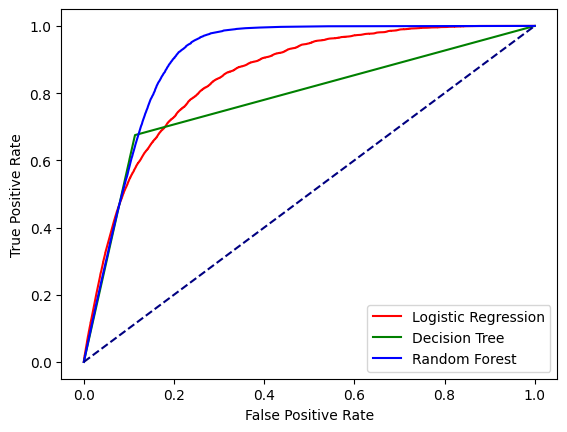

In [133]:
from sklearn.metrics import roc_curve


def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr

fpr_lrb, tpr_lrb = generate_roc(y_test, y_testpr_lr_base[:,1])
fpr_dtb, tpr_dtb = generate_roc(y_test, y_testpr_dt_base[:,1])
fpr_rfb, tpr_rfb = generate_roc(y_test, y_testpr_rf_base[:,1])

plt.plot(fpr_lrb, tpr_lrb,'-r')
plt.plot(fpr_dtb, tpr_dtb,'-g')
plt.plot(fpr_rfb, tpr_rfb,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression', 'Decision Tree','Random Forest'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

The a

## Training a model with sample records

In [134]:
df_subset = df.iloc[8::15]

After trying out different sampling methods, we have decided to take each record for every 15 records from the whole dataset.

In [135]:
# train test split of the subset dataset
X_trains, X_tests, y_trains, y_tests = train_test_split(df_subset[num_vars+cat_vars], df_subset["Left"], test_size=0.20)

print(f'Subset Training samples: {X_trains.shape[0]:,}')
print(f'Subset Test samples: {X_tests.shape[0]:,}')

Subset Training samples: 16,000
Subset Test samples: 4,000


## Logistic Regression (Regularization and Evaluation)

In [136]:
lo_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('log', LogisticRegression())]
)
lo_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('log', LogisticRegression())])

In [137]:
# Hyperparameters
lo_param_grid = [
    {
    'log__penalty': ['l1', 'l2'],  # Regularization type
    'log__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'log__solver': ['liblinear', 'saga'],  # Solver algorithm
    'log__class_weight': [None, 'balanced'],  # Class weight
    }
]

scoring ='f1'

lo_gc = GridSearchCV(estimator=lo_modeling_pipeline, param_grid=lo_param_grid, cv=5, scoring=scoring)

In [138]:
lo_gcv_results = lo_gc.fit(X_trains, y_trains)

In [198]:
lo_gcv_results.score(X_trains, y_trains)

0.6119636705292828

In [199]:
lo_gcv_results.score(X_tests, y_tests)

0.6125053168864313

In [139]:
lo_gcv_results.best_params_

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__penalty': 'l1',
 'log__solver': 'liblinear'}

### Model Evaluation

In [206]:
y_test_lr = lo_gcv_results.predict(X_tests)
y_testpr_lr = lo_gcv_results.predict_proba(X_tests)


In [207]:
print("ROC_AUC_lr ",(roc_auc_score(y_tests,y_test_lr)*100))
cf_lr = confusion_matrix(y_tests,y_test_lr)

ROC_AUC_lr  78.27412876813436


## Decision Tree (Regularization and Evaluation)

In [145]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('dt', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('dt', DecisionTreeClassifier())])

In [146]:
dt_param_grid = [
    {
    'dt__max_depth': [None, 10, 20],  # Maximum depth of the decision tree
    'dt__min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'dt__min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'dt__max_features': [ 'log2', None, 'sqrt'],  # Maximum number of features to consider for the best split
    'dt__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'dt__splitter': ['best', 'random']  # Strategy used to choose the split at each node
}
]

scoring ='f1'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)

In [147]:
dt_gcv_results = dt_gc.fit(X_trains, y_trains)

In [148]:
dt_gcv_results.best_params_

{'dt__criterion': 'entropy',
 'dt__max_depth': 10,
 'dt__max_features': None,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__splitter': 'best'}

In [149]:
dt_gcv_results.score(X_trains, y_trains)

0.7183012151712287

In [150]:
dt_gcv_results.score(X_tests, y_tests)

0.6825396825396824

### Model Evaluation

In [208]:
y_test_dt = dt_gcv_results.predict(X_tests)
y_testpr_dt = dt_gcv_results.predict_proba(X_tests)

In [209]:
print("ROC_AUC_dt ",(roc_auc_score(y_tests,y_test_dt)*100))
cf_dt = confusion_matrix(y_tests,y_test_dt)

ROC_AUC_dt  81.3763374157631


## Random Forest  (Regularization and Evaluation)

In [154]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('rf', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('rf', RandomForestClassifier())])

In [155]:
rf_param_grid = [
    {
    'rf__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'rf__max_depth': [None, 10, 20],  # Maximum depth of the trees
    'rf__min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'rf__max_features': ['sqrt', 'log2', None],  # Maximum number of features to consider for the best split
    'rf__criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}
]

scoring = 'f1'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)


In [157]:
rf_gcv_results = rf_gc.fit(X_trains, y_trains)

In [158]:
rf_gcv_results.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': 10,
 'rf__max_features': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 100}

In [159]:
rf_gcv_results.score(X_trains, y_trains)

0.7686369119420988

In [160]:
rf_gcv_results.score(X_tests, y_tests)

0.6964198136341344

The Train-Test f1-scores for Models are as below


*   Logistic Regression: 61.19%  and 61.25%
*   Decision Tree:       71.83%  and 68.25%
*   Random Forest:       76.86%  and 69.64%





### Model Evaluation


In [210]:
y_test_rf = rf_gcv_results.predict(X_tests)
y_testpr_rf = rf_gcv_results.predict_proba(X_tests)

In [211]:
print("ROC_AUC_rf ",(roc_auc_score(y_tests,y_test_dt)*100))
cf_rf = confusion_matrix(y_tests,y_test_dt)

ROC_AUC_rf  81.3763374157631


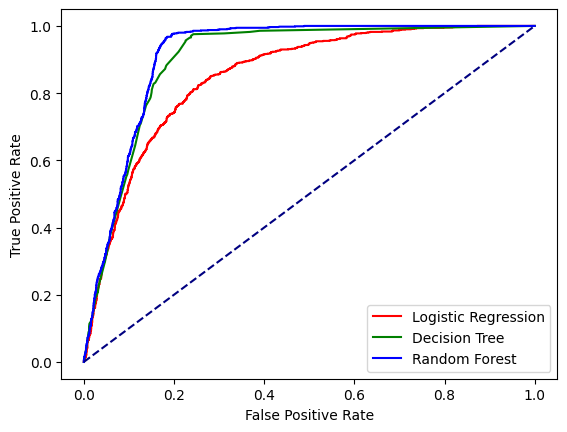

In [165]:
from sklearn.metrics import roc_curve


def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr

fpr_lr, tpr_lr = generate_roc(y_tests, y_testpr_lr[:,1])
fpr_dt, tpr_dt = generate_roc(y_tests, y_testpr_dt[:,1])
fpr_rf, tpr_rf = generate_roc(y_tests, y_testpr_rf[:,1])

plt.plot(fpr_lr, tpr_lr,'-r')
plt.plot(fpr_dt, tpr_dt,'-g')
plt.plot(fpr_rf, tpr_rf,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression', 'Decision Tree','Random Forest'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

# **Training all three models with best parameters for whole dataset**

In [166]:
from sklearn.model_selection import train_test_split

# train test split of the subset dataset
X_train, X_test, y_train, y_test = train_test_split(df[num_vars+cat_vars], df["Left"], test_size=0.95, random_state=42)

print(f'Subset Training samples: {X_train.shape[0]:,}')
print(f'Subset Test samples: {X_test.shape[0]:,}')

Subset Training samples: 15,000
Subset Test samples: 285,000


## Logistic Regression

In [167]:
#using existing best parameters stored in this model pipeline.
lo_modeling_pipeline.set_params(**lo_gcv_results.best_params_)

# Fit the pipeline on the training data
lo_modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('log',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))])

In [168]:
#train accuracy
lo_modeling_pipeline.score(X_train, y_train)

0.7644

In [169]:
#test accuracy
lo_modeling_pipeline.score(X_test, y_test)

0.7652070175438597

In [212]:
y_test_lo = lo_modeling_pipeline.predict(X_test)
y_testpr_lo = lo_modeling_pipeline.predict_proba(X_test)

In [213]:
print("ROC_AUC_lr ",(roc_auc_score(y_test,y_test_lo)*100))
cf_lr = confusion_matrix(y_test,y_test_lo)

ROC_AUC_lr  77.34021844327467


## Decision Tree

In [172]:
#using existing best parameters stored in this model pipeline.
dt_modeling_pipeline.set_params(**dt_gcv_results.best_params_)

# Fit the pipeline on the training data
dt_modeling_pipeline.fit(X_train, y_train)


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10))])

In [173]:
#train accuracy
dt_modeling_pipeline.score(X_train, y_train)


0.862

In [174]:
#test accuracy
dt_modeling_pipeline.score(X_test, y_test)

0.8407754385964912

In [214]:
y_test_dt = dt_modeling_pipeline.predict(X_test)
y_testpr_dt = dt_modeling_pipeline.predict_proba(X_test)

In [215]:
print("ROC_AUC_dt ",(roc_auc_score(y_test,y_test_dt)*100))
cf_dt = confusion_matrix(y_test,y_test_dt)

ROC_AUC_dt  82.41216574880296


## Random Forest

In [177]:
#using existing best parameters stored in this model pipeline.
rf_modeling_pipeline.set_params(**rf_gcv_results.best_params_)

# Fit the pipeline on the training data
rf_modeling_pipeline.fit(X_train, y_train)


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['SupervisorReview',
                                                   'Distance', 'SelfReview',
                                                   'Salary', 'YearsWorked',
                                                   'PreviousSalary']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DepartmentCode'])])),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_features=None,
                                        min_samples_split=5))])

In [178]:
#train accuracy
rf_modeling_pipeline.score(X_train, y_train)


0.8727333333333334

In [179]:
#test accuracy
rf_modeling_pipeline.score(X_test, y_test)

0.8467684210526316

In [216]:
y_test_rf = rf_modeling_pipeline.predict(X_test)
y_testpr_rf = rf_modeling_pipeline.predict_proba(X_test)

In [217]:
print("ROC_AUC_rf ",(roc_auc_score(y_test,y_test_rf)*100))
cf_rf = confusion_matrix(y_test,y_test_rf)

ROC_AUC_rf  83.35598577376948


The Train-Test f1-scores for Models are as below


*   Logistic Regression: 76.44%  and 76.65%
*   Decision Tree:       86.20%  and 84.07%
*   Random Forest:       87.27%  and 84.67%



## Comparision of models with best hyperparameters

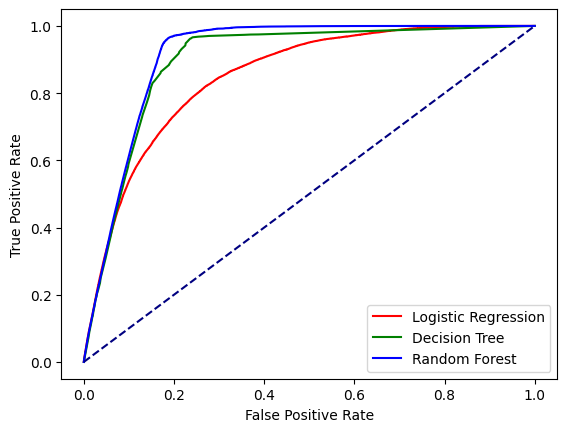

In [182]:
from sklearn.metrics import roc_curve


def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr

fpr_lr, tpr_lr = generate_roc(y_test, y_testpr_lo[:,1])
fpr_dt, tpr_dt = generate_roc(y_test, y_testpr_dt[:,1])
fpr_rf, tpr_rf = generate_roc(y_test, y_testpr_rf[:,1])

plt.plot(fpr_lr, tpr_lr,'-r')
plt.plot(fpr_dt, tpr_dt,'-g')
plt.plot(fpr_rf, tpr_rf,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression', 'Decision Tree','Random Forest'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

# Conclusion

After evaluating and comparing the performance of three models—Logistic Regression, Decision Tree, and Random Forest—we found that both Decision Tree and Random Forest performed equally well based on the F1-score metric.

However, we have selected Random Forest as the preferred model for this dataset. This decision is based on its superior ROC curve rate compared to Decision Tree. Given the unbalanced nature of the classification problem, the ROC curve's performance is particularly crucial, making Random Forest the optimal choice for this scenario.